# Updating **matplotlib**
For my function that compares Euler and RK2 integration at the end of Practicum 1-3, matplotlib's [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) are used to make it easier to compare multiple things at once. Unfortunately, it was added in matplotlib v3.4, and some Google Collab instances run versions older than that. 

Fortunately, we can run an update using the below cell. Once the update is run, the interpreter for the page must be restarted, which will be prompted automatically. The following cell should only need to be run **once** every time a runtime is connectd to the notebook.

In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 11.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


The below code verifies that our matplotlib version is greater than the required **v3.4** to allow for sub-figures.

In [ ]:
import matplotlib
print(matplotlib.__version__)

3.7.0


# Imports
All the imports necessary to do math & plot our results.

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from numpy.typing import ArrayLike
from typing import Tuple
from math import pi

# Practicum 1-1
Here is where my actual Practicum 1 begins. Doing the KVL loop of the circuit, we get:


$v_s(t)=v_R(t)+v_C(t)$

We know that $v_C(t)=v_0(t)$, so: 

$v_s(t)=v_R(t)+v_0(t)$

$v_s(t)=I_s(t)R+v_0(t)$

Since this simple circuit is in series, we know current is consistent throughout. Therefore, we can plugin the current equation for a capacitor into $I_s(t)$:

$v_s(t)=C\frac{dv}{dt}R+v_0(t)$

Once we solve for $\frac{dv}{dt}$:

$\frac{v_s(t)-v_0(t)}{CR}=\frac{dv}{dt}$

**rc_dynamics()** is the Python version of this model:

In [ ]:
def rc_dynamics(x: float, u: float) -> float:
  """Return evaluation of f(x,u).
  x: float : voltage output v_o
  u: float : voltage input v_s"""
  C = 1E-3
  R = 2E3
  return (u-x)/(C*R)

Below are the test calls I used to verify that my function worked.

 Test Values | Expected Output 
------|-------- 
$x$ = 0V, $u$ = 0V | input = output, expect 0
$x$ = 5V, $u$ = 0V | output > input, expect a negative value (capacitor discharging)
$x$ = 0V, $u$ = 5V | input > output, expect a positive value (capacitor charging)

In [ ]:
print(rc_dynamics(x=0,u=0))
print(rc_dynamics(x=5,u=0))
print(rc_dynamics(x=0,u=5))

0.0
-2.5
2.5


**EulerIteration()** is a data class Adam told me to write, which would genuinely be a better way of implementing my **EulerIntegration()** function later, but I didn't end up using it. The idea is that returning a list of **EulerIteration()** instances would be more clear and explicit than a 2D-array, as my implementation does.

In [ ]:
from dataclasses import dataclass

@dataclass
class EulerIteration:
  """Keeping track of euler integration."""
  f_x: float
  t: float
  u: float

**EulerIntegration()** is a function to perform Euler numeric integration on a passed function given initial conditions, $Δt$, and a range of $t$ values. It returns a 2D array of [x,y] values.

1. Create a result list and append the initial conditions for [x,y] to it. 
```
results = []
results.append([t_0, x_0])
```
1. Perform the estimation and append it to the result list.
```
x+1 =  x + delta_t * function(x, u)
t = t + delta_t
results.append(t, x)
```
1. Repeat **step 2** until t is less than the final t value.
```
while t < t_f:
```
1. Return the result.
```
return results
```

In [ ]:
def euler_integration(dyn_func: callable, 
                      u: float, 
                      x_0: float,
                      t_0: float, 
                      t_f: float, 
                      delta_t: float) -> list:
  """Perform a euler numeric integration.
  
  dyn_func: callable: dynamic function to integrate
  u: float: input voltage(constant)
  x_0: float: initial condition
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step size"""
  t = t_0
  x = x_0
  result = []
  result.append([t, x])
  while t < t_f:
    x = x + delta_t * dyn_func(x=x, u=u)
    t += delta_t
    result.append([t, x])
  return result

# Testing
**plot_many_steps()** automates plotting for a list of *delta_t* values to one figure, with a legend, with axis labeling and titles. It can be configured with custom x and y scales for uniformity.

1. Create a new figure.
```
figure()
```
1. Iterate through every delta_t and plot it.
```python
for delta in delta_t:
    result = integrate(my_func)
    plot(result)
```
1. Add labels.
```
ylabel("y")
xlabel("x")
```
1. Add custom ranges if provided.
```
if y_range:
    yticks(y_range)
if x_range:
    xticks(x_range)
```

In [ ]:
def plot_many_steps(dyn_func: callable, 
                    u: float, 
                    x_0: float,
                    duration: float, 
                    delta_t: list,
                    y_range: range=None,
                    x_range: range=None):
  """Plot the same function with different time steps.
  
  dyn_func: callable: function to plot
  u: float: input voltage(constant)
  x_0: float: initial condition
  duration: float: length of time to integrate over
  delta_t: list: list of different time step values to plot
  y_range: range: optional custom y-scale for plot
  x_range: range: optional custom x-scale for plot"""
  # Create a new figure
  plt.figure()
  
  # Plot every delta_t value
  for delta in delta_t:
    result = euler_integration(dyn_func=dyn_func,
                          u=u,
                          x_0=x_0,
                          t_0=0,
                          t_f=duration,
                          delta_t=delta)
    plt.plot([x[0] for x in result], [y[1] for y in result],
             label=f"$\Delta$t={delta}")
    
  # Adding appropriate labels
  plt.ylabel("$v_0(V)$")
  plt.xlabel("$t(s)$")
  plt.title(f"$U$={u}V $X_0$={x_0}V")
  plt.legend()
  
  
  # Applying custom ranges if necessary
  if y_range is not None:
    plt.yticks(y_range)
  if x_range is not None:
    plt.xticks(x_range)

Below are some constants set for the for all plots to keep consistency. Per the assignment, three **delta_t** values are plotted on each figure: *1, 0.1, 0.01.*

In [ ]:
duration = 10
delta_t_vals = [1, 0.1, 0.01]
y_range = range(0,10)

And now here are all my plots for the following data points:

 Input | Initial Condition 
------|-------- 
u = 5V | $x_0$ = 0V
u = 1V | $x_0$ = 1V
u = 0V | $x_0$ = 7.5V

Man, these Google Collab tables suck :( No vertical divider line.

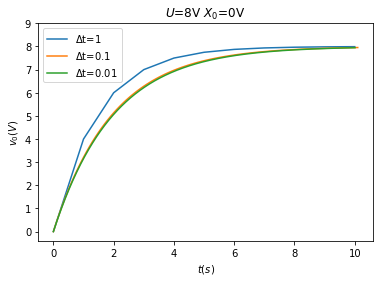

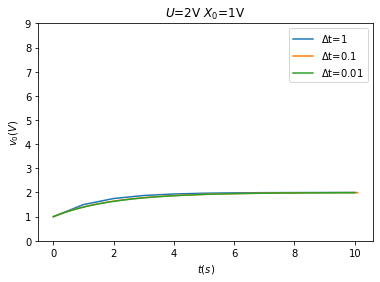

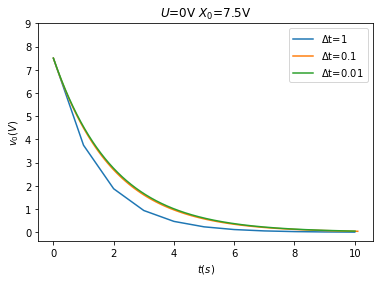

In [ ]:
plot_many_steps(dyn_func=rc_dynamics,
                u=8,
                x_0=0,
                duration=duration,
                delta_t=delta_t_vals,
                y_range=y_range)

plot_many_steps(dyn_func=rc_dynamics,
                u=2,
                x_0=1,
                duration=duration,
                delta_t=delta_t_vals,
                y_range=y_range)

plot_many_steps(dyn_func=rc_dynamics,
                u=0,
                x_0=7.5,
                duration=duration,
                delta_t=delta_t_vals,
                y_range=y_range)

# Results
All three plots match predictions based on how capacitors react to a potential difference.

 Input | Initial Condition | Prediction
------|-------- | -------
u = 8V | $x_0$ = 0V | Input > Output: capacitor will charge.
u = 2V | $x_0$ = 1V | Input > Output: capacitor will discharge.
u = 0V | $x_0$ = 7.5V | Output < Input: capacitor will discharge.

The different shapes of the $Δt$ values also match predictions. The largest $Δt$ value of 1 is the most jagged aka "low resolution" which makes sense, as the $Δt$ value determines the period of estimations made. So, higher period would expect "lower resolution" and more jagged results.

$Δt=0.1$ and $Δt=0.01$ look incredibly similar, which makes sense, as these are both relatively "high resolution" for the time scale of 10 seconds being plotted.

# Reflection
Everything worked as expected. I'm very glad we had the prep work to do ahead of time, as it cut out a lot of the cruft of having to google for syntax during the practicum period - by allowing us to copy and paste what we'd already written, haha. On that note, it's clear that the more effort put into the pre-practicum, the smoother the practicum section will go. I'm glad Dylan showed me how to use LaTeX with matplotlib, as it helped the readability of my plots immensely.

I'm also glad I spent the time to make a function that plots across many $Δt$ values. This allowed me to make better plots more easily and improves the readability of the code immensely.



# Practicum 1-2
**u_func()** is a simple function to model a sinusoidal input function, providing optional parameters to modify the amplitude, period, and phase shift.

1. Return the result at time t.
```
return A * sin(omega * t + phi)
```

In [ ]:
def u_func(t: float,
           A: float=5.0,
           omega: float=2.0 * math.pi,
           phi: float=0) -> float:
  """Return sinusoidal input function at t.
  t: float: time value to evaluate
  A: float: amplitude of the sin wave
  omega: float: period of the sin wave
  phi: float: phase shift of the sin wave"""
  return A * math.sin(omega * t + phi)

# Euler integration
**euler_integration()** is a function to perform Euler numeric integration on a passed function given initial conditions, an input function, $Δt$, and a range of $t$ values. It returns a 2D array of [x,y] values.

1. Create a result list and append the initial conditions for [x,y] to it. 
```
results = []
results.append([t_0, x_0])
```
1. Perform the estimation and append it to the result list.
```
x+1 =  x + delta_t * function(x, u(t))
t = t + delta_t
results.append(t, x)
```
1. Repeat **step 2** until t is less than the final t value.
```
while t < t_f:
```
1. Return the result.
```
return results
```

In [ ]:
def euler_integration(dyn_func: callable, 
                      u: callable, 
                      x_0: float,
                      t_0: float, 
                      t_f: float, 
                      delta_t: float) -> list:
  """Perform a euler numeric integration.
  
  dyn_func: callable: dynamic function to integrate
  u: callable: input voltage(as a func of time)
  x_0: float: initial condition
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step size"""
  t = t_0
  x = x_0
  result = []
  result.append([t, x])
  while t < t_f:
    x = x + delta_t * dyn_func(x=x, u=u(t))
    t += delta_t
    result.append([t, x])
  return result

# RK2 integration
**rk2_integration()** is an implenetation of the Runge-Kutta integrator. As shown in the [great video by Steve Brunton](https://youtu.be/HOWJp8NV5xU), each RK2 estimation step can be broken down into three sub-steps: 

1. $f_1 = f(x_k, u_k(t_k))$
1. $f_2 = f(x_k + \frac{Δt}{2}f_1, u_k(t_k + \frac{Δt}{2}))$
1. $x_{k+1} = x_k + Δtf_2$

These will be used in our algorithm, as can be seen below.

1. Generate our t values from our passed **t_0**, **t_f**, and **delta_t** values.
```
t_vals = range(t0, t_f, delta_t)
```
1. Create a list to hold our result and start it with our initial conditions.
```
result = []
result.append([t_0, x_0])
```

1. Peform the estimation and append the result to the result list - following the equation shown above.
```
  f_1 = f(x=x_k,u=u_func(t))
  f_2 = f(x=x_k + delta_t/2*f_1, u=u_func(t+delta_t/2))
  x_k1 = x_k + delta_t*f_2

  result.append([t, x_k1])
```

1. Return the result.
```
return result
```

In [ ]:
def rk2_integration(dyn_func: callable, 
                    u: callable, 
                    x_0: float,
                    t_0: float, 
                    t_f: float, 
                    delta_t: float) -> list:
  """Perform Runge-Kutta integration.
  
  dyn_func: callable: dynamic function to integrate
  u: callable: input voltage(as a func of time)
  x_0: float: initial condition
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step size"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Create result list
  result = []
  result.append([t_0, x_0])
  for i in range(1, len(t_vals)):
    # Creating temp variables to ease equation-writing
    t = t_vals[i]
    x_k = result[i-1][1]

    f_1 = rc_dynamics(x=x_k,u=u(t))
    f_2 = rc_dynamics(x=x_k + delta_t/2*f_1, u=u(t+delta_t/2))

    x_k1 = x_k + delta_t*f_2
    
    result.append([t, x_k1])
  return result

Adam and I were discussing the best, most pythonic way to implment the loop I have in **rk2_integration()** and below is the prototype he wrote to show me how he'd go about it. I still prefer my way of, sort of, "aliasing" the values by creating temp variables.



In [ ]:
def adam_example():
  """Adam showed me an interesting way to handle iterators."""
  x_vals = [x_0]
  t_vals = np.arange(0, T, step=0.1)

  for t in t_vals:
      x_k = x[-1]
      f_1 = rc_dynamics(x=x_k,u=u_func(t))
      f_2 = rc_dynamics(x=x_k + delta_t/2*f_1, u=u_func(t+delta_t/2))

      x_vals.append(x[-1] + delta_t*f_2)

# Testing
**compare_integrators()** automates plotting two integration types to a subplot, with one plot for each *delta_t* value. It includes a legend, axis labeling, and titles. It can be configured with custom x and y scales for uniformity, and can optionally plot the input signal.

1. Create a new figure.
```
figure()
```
1. Iterate through every delta_t, plot it, and label it.
```python
for delta in delta_t:
    result1 = euler(my_func)
    result2 = rk2(my_func)
    plot(result1)
    plot(result2)
    ylabel("y")
    xlabel("x")
```
1. (still in the loop) Optionally plot the input function.
```
if plot_u:
    plot(u)
```
1. (after exiting the loop) Add an overall figure title.
```
suptitle("google's markdown sucks")
```
1. Add custom ranges if provided.
```
if y_range:
    yticks(y_range)
if x_range:
    xticks(x_range)
```

In [ ]:
def compare_integrators(dyn_func: callable, 
                        u: callable,
                        x_0: float,
                        duration: float, 
                        delta_t: list,
                        y_range: range=None,
                        x_range: range=None,
                        plot_u: bool=False):
  """Plot the same function with different time steps
  and both integrators.
  
  dyn_func: callable: function to plot
  u: callable: input voltage
  x_0: float: initial condition
  duration: float: length of time to integrate over
  delta_t: list: list of different time step values to plot
  y_range: range: optional custom y-scale for plot
  x_range: range: optional custom x-scale for plot
  plot_u: boolean: optionally print the input function"""
  
  # Create a new figure
  plt.figure(figsize=(30, 5))
  
  for i in range(len(delta_t)):
    plt.subplot(1, len(delta_t), i+1)
    result = euler_integration(dyn_func=dyn_func,
                              u=u,
                              x_0=x_0,
                              t_0=0,
                              t_f=duration,
                              delta_t=delta_t[i])
    plt.plot([x[0] for x in result], [y[1] for y in result],
              label=f"Euler")
    result = rk2_integration(dyn_func=dyn_func,
                              u=u,
                              x_0=x_0,
                              t_0=0,
                              t_f=duration,
                              delta_t=delta_t[i])
    plt.plot([x[0] for x in result], [y[1] for y in result],
              label=f"RK2")
    
    # Optionally plotting the input signal
    if plot_u:
      plt.plot([x[0] for x in result], [u_func(x[0]) for x in result],
               marker="*", label="u(t)")
    
    
    # Adding appropriate labels
    plt.title(f"$\Delta$t={delta_t[i]}")
    plt.ylabel("$v_0(V)$")
    plt.xlabel("$t(s)$")
    plt.legend()
    
  # Adding a figure title
  plt.suptitle(f"$x_0$: {x_0}V", fontsize=14)
  
  # Applying custom ranges if necessary
  if y_range is not None:
    plt.yticks(y_range)
  if x_range is not None:
    plt.xticks(x_range)

These are some constants set for the for all plots to keep consistency. Per the assignment, three **delta_t** values are plotted on each figure: *1, 0.1, 0.01.*

In [ ]:
# Setting up constants
duration = 10
delta_t_vals = [1, 0.1, 0.01]
y_range = range(0,10)

Below are plots for the varying values of $x_0$, comparing between 
**Euler** and **RK2** implementations for each time step. Three separate code
blocks were used because the massive 3x3 figure of plots I originally tried was so big that Google Collab gave it a separate scroll bar, and it was a chore to navigate through.

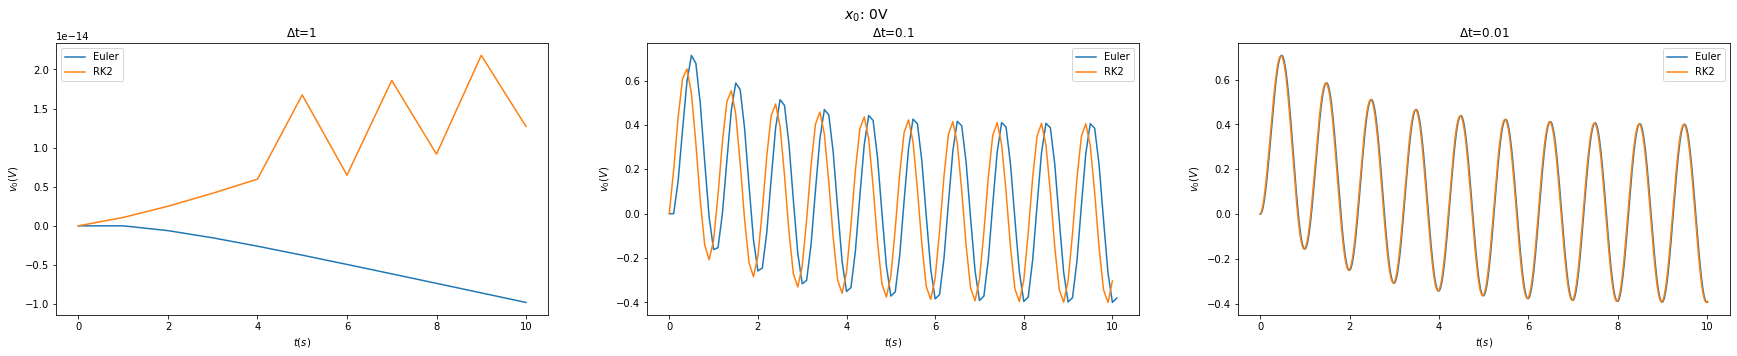

In [ ]:
compare_integrators(dyn_func=rc_dynamics,
                    u=u_func,
                    x_0=0,
                    duration=duration,
                    delta_t=delta_t_vals)

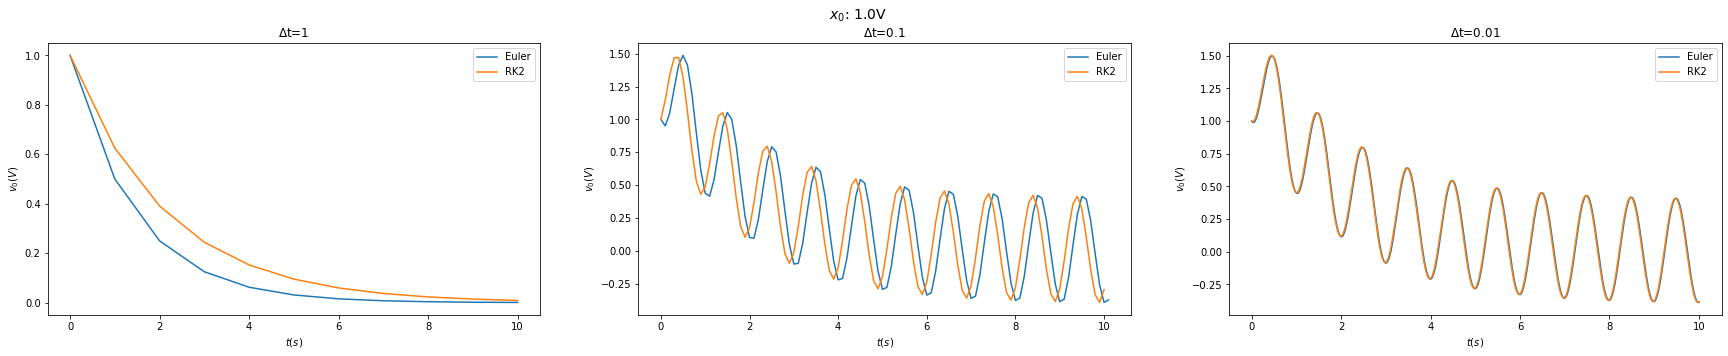

In [ ]:
compare_integrators(dyn_func=rc_dynamics,
                    u=u_func,
                    x_0=1.0,
                    duration=duration,
                    delta_t=delta_t_vals)

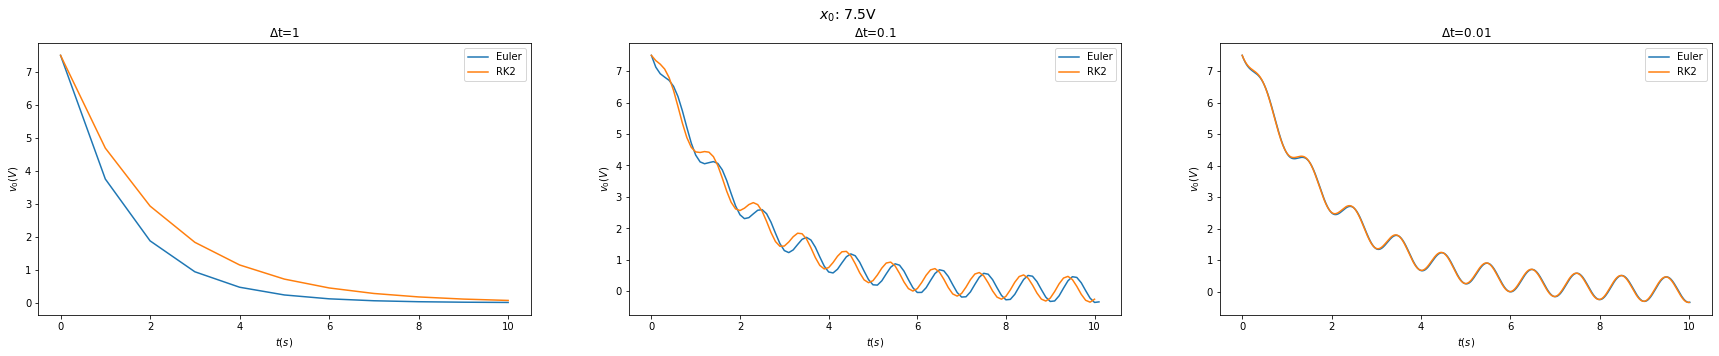

In [ ]:
compare_integrators(dyn_func=rc_dynamics,
                    u=u_func,
                    x_0=7.5,
                    duration=duration,
                    delta_t=delta_t_vals)

# Results
At a $\Delta t$ value of 0.01, Euler and RK2 look practically identical. However, at the larger step sizes of 0.1 and 1, the advantages of RK2 over Euler can be seen as the resulting outputs diverge from each other. To be fully accurate, we would need to plot the analytical solution to technically know which one has the lower % error - but at a $Δt$ of 1, it's clear RK2 is superior.

The plot of $\Delta t=1$ where $x_0=0$ looks quite strange. Our input function is a sinusoid, and at an initial condition of zero, with such a low sampling resolution, we're only sampling the function when it's at or near zero. This causes our plot to stick near zero - which is what we see happening. Note the **"1e-14"** at the top left of the plot - these are *incredibly* small values

# Reflection
Overall, no real surprises here - at the lower sample resolution, it's clear RK2 is superior. It is neat to see how, when the resolution increases, they become more and more similar. Increasing the resolution by decreasing $\Delta t$ can become computationally expensive quickly - so having RK2 as an accurate option at a lower resolution / higher $\Delta t$ is valuable for us, especially as the duration of plots increase.

# Practicum 1-3
**pendulum_dynamics()** implements the following pendulum equation:

$ml^2\ddot{θ}(t)+b\dot{\theta}(t)+mgl\sin{\theta}(t)=u(t)$

Utilizing **state variables**, we can identify the following relationships:

$x_1\equiv\theta, x_2\equiv\dot{\theta}$

Once we take the derivitave of these, we find that:

$\dot{x_1}=\dot{\theta}=x_2$

$\dot{x_2}=\ddot{\theta}$

We've now converted the second-order system into a first-order one! Go us! Now we can take our first equation and solve for $\ddot{\theta}$:

$ml^2\ddot{θ}(t)=u(t)-b\dot{\theta}(t)-mgl\sin{\theta}(t)$

$\ddot{θ}(t)=\frac{u(t)-b\dot{\theta}(t)-mgl\sin{\theta}(t)}{ml^2}$

Now we have everything we need to solve this equation! We pass **pendulum_dynamics()** the initial conditions $x_1$ and $x_2$, and it returns $\dot{x_1}$ and $\dot{x_2}$ via the equations derived above.

In [ ]:
def pendulum_dynamics(x: ArrayLike,
                      u: float,
                      m: float=0.5,
                      l: float=0.2,
                      b: float=1.0,
                      g: float=9.8) -> ArrayLike:
  """Pendulum dynamic equation that takes 2 dimensional array
  as initial conditions. Given x1 and x2, return x1dot and x2dot.
  
  x: ArrayLike: initial conditions
  u: callable: input voltage(as a func of time)
  m: float: mass of pendulum
  l: float: length of pendulum
  b: float: damping coefficient of pendulum
  g: float: gravity in m/s"""
  theta = x[0]
  theta_dot = x[1]

  theta_d_dot = (u-b*theta_dot - m*g*l*math.sin(theta))
  theta_d_dot *= 1/(m*l*l)

  x_1_dot = theta_dot
  x_2_dot = theta_d_dot
  return np.array([x_1_dot, x_2_dot])

**Testing pendulum dynamics:**
To test that the pendulum model was implemented correctly, a suite of tests will be completed using assert statements:

1. Checking acceleration is positive when released from rest at a negative position.
1. Checking acceleration is negative when released from rest at a positive position.
1. Checking acceleration is zero when released at the bottom of its swing.


In [ ]:
# Checking acceleration is positive when released from rest at a negative position
assert pendulum_dynamics(x=[-pi/4, 0], u=0)[1]>0 

# Checking acceleration is negative when released from rest at a positive position
assert pendulum_dynamics(x=[pi/4, 0], u=0)[1]<0 

# Checking acceleration is zero when released at the bottom of its swing
assert pendulum_dynamics(x=[0,0], u=0)[0]==0 

# Euler integration
**euler_integration()** is a function to perform Euler numeric integration on a passed function given initial conditions, an input function, $Δt$, and a range of $t$ values. It returns a 2D array of [x,y] values. As shown in **equation 3** on [this wonderful website](https://tutorial.math.lamar.edu/classes/de/eulersmethod.aspx) that has a derivation, each iteration of the formula can be summarized as follows:

$x_{k+1}=x_k+Δtf(x)$

The algorithm implemented can be seen below:

1. Generate our t values from our passed **t_0**, **t_f**, and **delta_t** values.
```
t_vals = arrange(t0, t_f, delta_t)
```
1. Create a result list and append the initial conditions for [x,y] to it. 
```
x_vals = np.zeros()
x_vals[0] = (x_0)
```
1. Loop through *t values*. Perform estimation and append x_k1 value to the result list - following the equation shown above.
```
for i in range(t_vals):
    x_k_1 =  x_k + delta_t * function(x, u(t))
    x_vals[i] = x_k_1
```
1. Return x values and t values as a tuple.
```
return t_vals, x_vals
```

In [ ]:
def euler_integration(dyn_func: callable, 
                      u: callable, 
                      x_0: ArrayLike,
                      t_0: float, 
                      t_f: float, 
                      delta_t: float,
                      m: float=0.5,
                      l: float=0.2,
                      b: float=1.0) -> Tuple[ArrayLike, ArrayLike]:
  """Perform a euler numeric integration.
  
  dyn_func: callable: dynamic function to integrate
  u: callable: input voltage(as a func of time)
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  m: float: mass of pendulum
  l: float: length of pendulum
  b: float: damping coefficient of pendulum
  delta_t: float: time step size"""
  # Generating T Values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)
  
  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0
  
  # Iterating
  for i in range(1, len(t_vals)):
    t = t_vals[i-1]
    x_k = x_vals[i-1]

    x_k_1 = x_k + delta_t * dyn_func(x=x_k, u=u(t), m=m, l=l, b=b)
    x_vals[i] = x_k_1


  return t_vals, x_vals

# RK2 integration
**rk2_integration()** is an implenetation of the Runge-Kutta integrator. It returns a tuple of t values and n-dimensional x values. As shown in the [great video by Steve Brunton](https://youtu.be/HOWJp8NV5xU), each RK2 estimation step can be broken down into three sub-steps: 

1. $f_1 = f(x_k, u_k(t_k))$
1. $f_2 = f(x_k + \frac{Δt}{2}f_1, u_k(t_k + \frac{Δt}{2}))$
1. $x_{k+1} = x_k + Δtf_2$

These will be used in our algorithm, as can be seen below.

1. Generate our t values from our passed **t_0**, **t_f**, and **delta_t** values.
```
t_vals = arrange(t0, t_f, delta_t)
```
1. Create a list to hold our result and start it with our initial conditions.
```
x_vals = np.zeros()
x_vals[0] = (x_0)
```

1. Loop through t values. Perform estimation and append x_k1 value to the result list - following the equation shown above.
```
  for i in range(t_vals):
    f_1 = f(x=x_k,u=u_func(t))
    f_2 = f(x=x_k + delta_t/2*f_1, u=u_func(t+delta_t/2))
    x_k1 = x_k + delta_t*f_2

    x_vals[i] = x_k1
```

1. Return x values and t values as a tuple.
```
return t_vals, x_vals
```

In [ ]:
def rk2_integration(dyn_func: callable, 
                    u: callable, 
                    x_0: ArrayLike,
                    t_0: float, 
                    t_f: float, 
                    delta_t: float,
                    m: float=0.5,
                    l: float=0.2,
                    b: float=1.0) -> list:
  """Perform Runge-Kutta integration.
  
  dyn_func: callable: dynamic function to integrate
  u: callable: input voltage(as a func of time)
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  m: float: mass of pendulum
  l: float: length of pendulum
  b: float: damping coefficient of pendulum
  delta_t: float: time step size"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  for i in range(1, len(t_vals)):
    # Creating temp variables to ease equation-writing
    t = t_vals[i-1]
    x_k = x_vals[i-1]

    f_1 = dyn_func(x=x_k,u=u(t), m=m, l=l, b=b)
    f_2 = dyn_func(x=x_k + delta_t/2*f_1, u=u(t+delta_t/2), m=m, l=l, b=b)

    x_k_1 = x_k + delta_t*f_2
    x_vals[i] = x_k_1
  return t_vals, x_vals

# Comparing integrators
**compare_integrators()** plots a dynamic function across a list of $\Delta t$ values with two different integrators to allow for comparison. It utilizes [sub-figures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) introduced in matplotlib v3.4 to improve plot readability. I spent a while (4+ hrs) just diving into the docs about subplots / subfigures and how to use them to make this plot look good, so hopefully it was time well-spent!

1. Create the figure
```
fig = plt.figure()
fig.legend()
fig.suptitle('x_1=x_1, x_2=x_2, m=m, l=l, b=b')
subfigs = fig.subfigures()
```
1. Enter loop for all delta_t values
```
for i in range(delta_t)
```
  1. Prep for this delta_t segment.
  ```
  subfigs[0, i].suptitle("Delta_t=delta_t(i)")
  ```
  1. Plot Euler *x_1 vs. time.*
  ```
    axs = subfigs[0, i].subplots(1,2)
    t_vals, x_vals = euler_integration()
    
    axs[0].plot(t_vals, x_vals[0])
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Position (x_1)")
  ```
  1. Plot Euler *x_2 vs. time.*
  ```
    axs[1].plot(t_vals, x_vals[1])
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Position (x_2)")
  ```
  1. Plot RK2 *x_1 vs. time.*
  ```
    axs = subfigs[1, i].subplots(1,2)
    t_vals, x_vals = rk2_integration()
    
    axs[0].plot(t_vals, x_vals[0])
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Position (x_1)")
  ```
  1. Plot RK2 *x_2 vs. time.*
  ```
  axs[1].plot(t_vals, x_vals[1])
  axs[1].set_xlabel("Time (s)")
  axs[1].set_ylabel("Position (x_2)")
  ```

In [ ]:
def compare_integrators(dyn_func: callable,
                        u: callable,
                        x_0: ArrayLike,
                        duration: float, 
                        delta_t: list,
                        m: float,
                        l: float,
                        b: float):
  """Plot the same function across different time steps with
  two integrators.
  
  dyn_func: callable: function to plot
  u: callable: input function
  x_0: float: initial condition
  duration: float: length of time to integrate over
  delta_t: list: list of different time step values to plot
  m: float: mass of pendulum
  l: float: length of pendulum
  b: float: damping coefficient
  y_range: range: optional custom y-scale for plot
  x_range: range: optional custom x-scale for plot"""
  
  # Create a new figure
  fig = plt.figure(constrained_layout=True, 
                   figsize=(5*len(delta_t), 5))
  euler_color = '#FFEAB3'
  rk2_color = '#E5E5E5'
  euler_patch = mpatches.Patch(color=euler_color, label="Euler")
  rk2_patch = mpatches.Patch(color=rk2_color, label="RK2")
  fig.legend(handles=[euler_patch, rk2_patch],
             loc='outside lower center',
             fontsize='x-large')
  fig.suptitle(f"$x_1=${x_0[0]:.3f}, $x_2=${x_0[1]:.3f}, m={m}, l={l}, b={b}",
               fontsize='x-large')
  subfigs = fig.subfigures(2, len(delta_t), hspace=0, wspace=0.05)
  
  # Plotting across all delta_t
  for i in range(len(delta_t)):
    # Euler ------
    axs = subfigs[0, i].subplots(1,2)
    subfigs[0, i].suptitle(f"$\Delta$T={delta_t[i]}",
                           fontsize='x-large')
    subfigs[0, i].set_facecolor(euler_color)
    t_vals, x_vals = euler_integration(dyn_func=dyn_func,
                                       u=u,
                                       x_0=x_0,
                                       t_0=0,
                                       t_f=duration,
                                       m=m,
                                       l=l,
                                       b=b,
                                       delta_t=delta_t[i])
    # x1 v time
    axs[0].plot(t_vals, [x[0] for x in x_vals])
    axs[0].set_xlabel("Time $(s)$")
    axs[0].set_ylabel("Position $(x_1)$")

    # x2 v time
    axs[1].plot(t_vals, [x[1] for x in x_vals], color="red")
    axs[1].set_xlabel("Time $(s)$")
    axs[1].set_ylabel("Speed $(x_2)$")

    # RK2 -------
    axs = subfigs[1, i].subplots(1,2)
    subfigs[1, i].set_facecolor(rk2_color)
    t_vals, x_vals = rk2_integration(dyn_func=dyn_func,
                                     u=u,
                                     x_0=x_0,
                                     t_0=0,
                                     t_f=duration,
                                     m=m,
                                     l=l,
                                     b=b,
                                     delta_t=delta_t[i])
    # x1 v time
    axs[0].plot(t_vals, [x[0] for x in x_vals])
    axs[0].set_xlabel("Time $(s)$")
    axs[0].set_ylabel("Position $(x_1)$")

    # x2 v time
    axs[1].plot(t_vals, [x[1] for x in x_vals], color="red")
    axs[1].set_xlabel("Time $(s)$")
    axs[1].set_ylabel("Speed $(x_2)$")

# Plotting the Pendulum
**plot_pendulum()** plots a pendulum across a list of damping values to allow for comparison. It utilizes [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) to plot both *position v time* and *speed v position* plots in the same loop for each damping function, and stack them vertically. Quite frankly this could be made to look a lot nicer using subfigures like in **compare_integrators()**, but I've already spent 4-6 hours working on that one and this one looks good enough for now. From here on out, I'll be utilizing a structure similar to **compare_integrators()** for my plotting, but it was out of scope for this practicum to refactor this function.

1. Create the figure
```
plt.figure()
plt.subplots_adjust()
plt.suptitle('x_1=x_1, x_2=x_2, m=m, l=l, delta_t=delta_t')
```
1. Enter loop for all delta_t values
```
for i in range(b):
```
  1. Plot position v time.
  ```
  plt.subplot(2, len(b), i+1)
    t_vals, x_vals = integrator()
    plt.plot(t_vals, x[0])
  ```
  1. Label it.
  ```
  plt.xlabel("Time (s)")
  plt.ylabel("Position (x_1)")
  ```
  1. Plot speed v position.
  ```
  plt.subplot(2, len(b), i+(1+len(b)))
  plt.plot(x[0], x[1])
  ```
  1. Label it.
  ```
  plt.xlabel("Position (x_1)")
  plt.ylabel("Speed (x_2)")
  ```

In [ ]:
def plot_pendulum(dyn_func: callable,
                  integrator: callable, 
                  u: callable,
                  x_0: ArrayLike,
                  duration: float, 
                  delta_t: float,
                  m: float,
                  l: float,
                  b: list):
  """Plot the pendulum model across a list of damping values.
  
  dyn_func: callable: function to plot
  integrator: callable: integrator to use when plotting
  u: callable: input voltage
  x_0: ArrayLike: initial conditions
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  m: float: mass of pendulum
  l: float: length of pendulum
  b: list: damping coefficients to plot side-by-side"""
  
  # Create a new figure
  plt.figure(figsize=(15, 5))
  plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
  plt.suptitle(f"$x_1=${x_0[0]:.3f}, $x_2=${x_0[1]:.3f}, m={m}, l={l}, $\Delta T$={delta_t}",
               fontsize='x-large')
  for i in range(len(b)):
    plt.subplot(2, len(b), i+1)
    t_vals, x_vals = integrator(dyn_func=dyn_func,
                              u=u,
                              x_0=x_0,
                              t_0=0,
                              t_f=duration,
                              m=m,
                              l=l,
                              b=b[i],
                              delta_t=delta_t)
    plt.plot(t_vals, [x[0] for x in x_vals])
    
    # Adding appropriate labels
    plt.title(f"$B$={b[i]}")
    plt.xlabel("Time $(s)$")
    plt.ylabel("Position $(x_1)$")

    plt.subplot(2, len(b), i+(1+len(b)))
    plt.plot([x[0] for x in x_vals], [x[1] for x in x_vals])
    
    # Adding appropriate labels
    plt.xlabel("Position $(x_1)$")
    plt.ylabel("Speed $(x_2)$")

# **Evaluation 1**: comparing Euler and RK2 for the pendulum
$b=0.05$ was used instead of $b=0.5$, as this showed a more gradual increase of graph quality as resolution increased. This will be explored in the evaluation below.

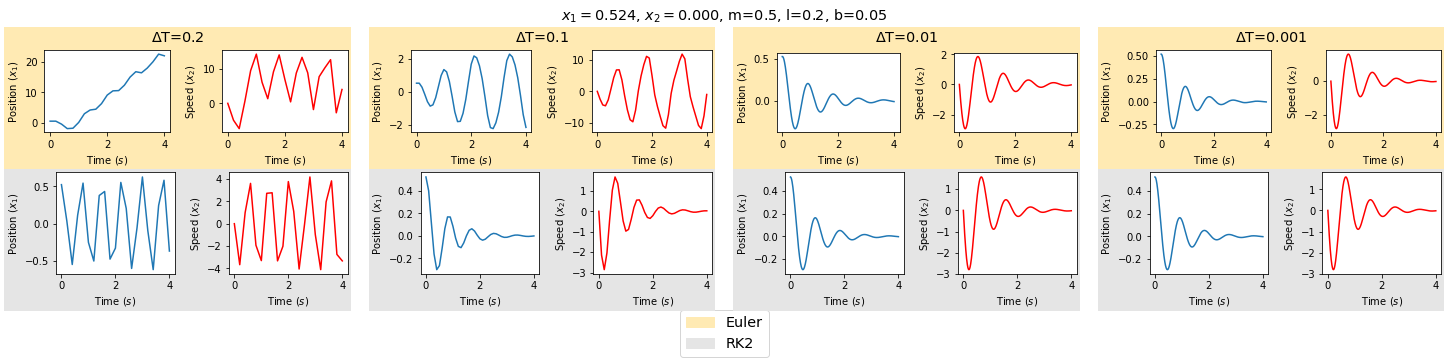

In [ ]:
m = 0.5
l = 0.2
b = 0.05
delta_t_vals = [0.2, 0.1, 0.01, 0.001]
duration = 4

compare_integrators(dyn_func=pendulum_dynamics,
                    u=lambda u: 0,
                    x_0=np.array([pi/6, 0]),
                    duration=duration, 
                    delta_t=delta_t_vals,
                    m=m,
                    l=l,
                    b=b)

As $\Delta t$ decreases, the quality of the graph increases, as expected. At $\Delta t=0.1$, we can see why RK2 is  better than Euler: RK2 actually gives us roughly the output we expect, whereas Euler is incorrect. For $\Delta t=0.01$ and $\Delta t=0.001$, the outputs of the two integrators are very similar. RK2 is so superior because being able to evaluate at lower resolutions saves on computational overhead. It should be noted that at $\Delta t=0.2$, they're both very wrong, but Euler does manage to be *more* wrong.

As previously mentioned, these plots were all at $b=0.05$. I think this shows a nice progression across the range of $\Delta t$ values: very wrong -> Euler wrong but RK2 roughly correct -> both correct -> both correct. Below, I also ran the same plots, but with the suggested $b=0.5$:

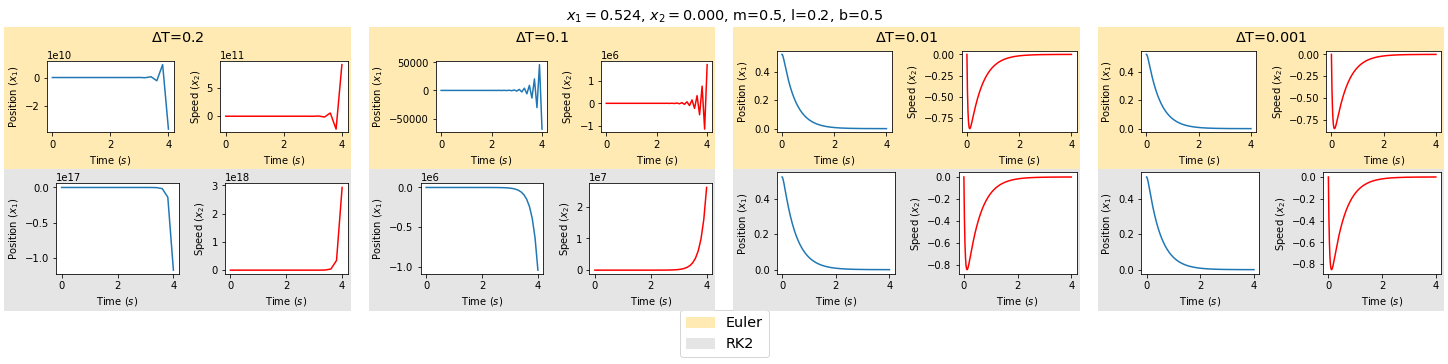

In [ ]:
m = 0.5
l = 0.2
b = 0.5
delta_t_vals = [0.2, 0.1, 0.01, 0.001]
duration = 4

compare_integrators(dyn_func=pendulum_dynamics,
                    u=lambda u: 0,
                    x_0=np.array([pi/6, 0]),
                    duration=duration, 
                    delta_t=delta_t_vals,
                    m=m,
                    l=l,
                    b=b)

... yeah it looks pretty gross.  Here, even when the plots are accurate($\Delta t=0.01$ and $\Delta t=0.001$), they don't look like what I'd expect from a swinging pendulum. They just fall into place and rest there because the damping is so high. The progression in these graphs from incorrect -> correct is not nearly as clear, so I prefer evaluation at $b=0.05$.

# **Evaluation 2:** Comparing different damping values

**$Δt=0.01$** was chosen instead of **0.1** because it shows a less drastic fall-off in plot quality when increasing the damping values from **0.05** to **1.5**. That's also why I also added an intermediary step of **$b=0.1$**: to show more gradually how increasing damping affects the motion of a pendulum.

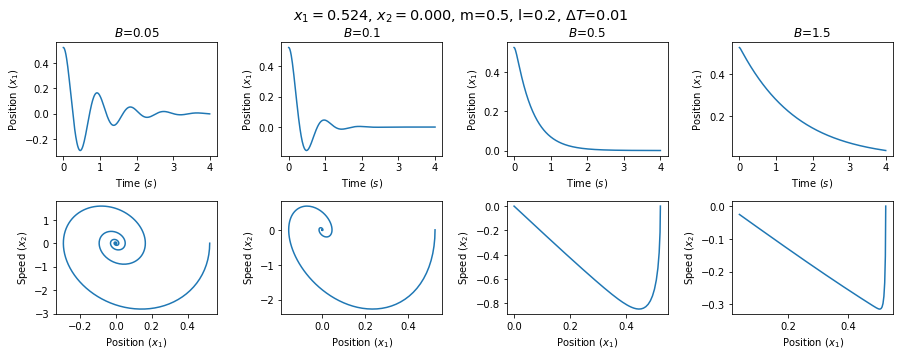

In [ ]:
b_vals = [0.05, 0.1, 0.5, 1.5]
duration = 4
delta_t = 0.01
m = 0.5
l = 0.2

plot_pendulum(dyn_func=pendulum_dynamics,
              integrator=rk2_integration, 
              u=lambda u: 0,
              x_0=np.array([pi/6, 0]),
              duration=duration, 
              delta_t=delta_t,
              m=m,
              l=l,
              b=b_vals)

With increased damping, the pendulum swings less and less. Considering that damping by definition inhibits the movement of a pendulum, this is exactly what we expect.

Below is the plot with the values as directly given in the handout for **Evaluation 2:**

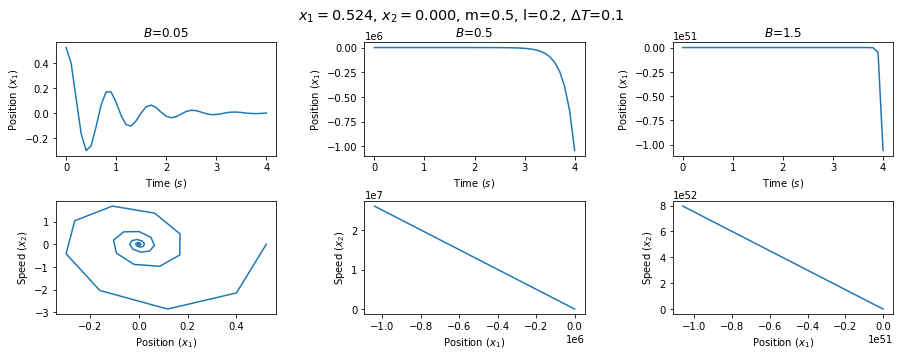

In [ ]:
b_vals = [0.05, 0.5, 1.5]
duration = 4
delta_t = 0.1
m = 0.5
l = 0.2

plot_pendulum(dyn_func=pendulum_dynamics,
              integrator=rk2_integration, 
              u=lambda u: 0,
              x_0=np.array([pi/6, 0]),
              duration=duration, 
              delta_t=delta_t,
              m=m,
              l=l,
              b=b_vals)

The first plot at $B=0.05$ looks roughly okay, but the quality of the plots drop off pretty fast, which makes it hard to tell what's happening. I didn't fully understand the consequences of increasing damping until I used more gradual values, as explained with the previous plots.

# **Repeating** Eval 2
Here, we're plotting the same system as before, but with a constant input (**$u=1$**) instead of no input (**$u=0$**).

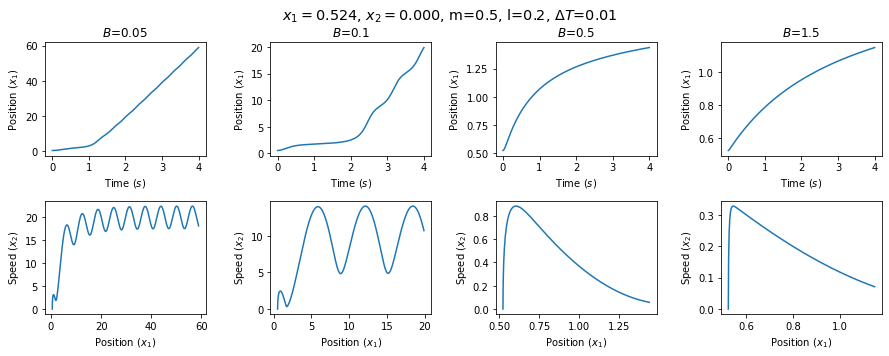

In [ ]:
b_vals = [0.05, 0.1, 0.5, 1.5]
duration = 4
delta_t = 0.01
m = 0.5
l = 0.2

plot_pendulum(dyn_func=pendulum_dynamics,
              integrator=rk2_integration, 
              u=lambda u: 1.0,
              x_0=np.array([pi/6, 0]),
              duration=duration, 
              delta_t=delta_t,
              m=m,
              l=l,
              b=b_vals)

With a constant input, the pendulum just keeps spinning more and more in the positive direction, as can be seen on the position plots. The pendulum behavior where gravity works with the input to increase the speed can still be seen in the sinusoidal-ish plots of the speed vs position graphs for the lower damping values.

With **low** damping values ($b=0.05$ and $b=0.1$) the position value vs time plot is almost linear after the initial second and a half or so. For **higher** damping values ($b=0.5$ and $b=1.5$), the position seems to be slowly approaching a resting value over time. This is also reflected in the speed vs position plots, as speed is approaching zero as the position increases.

# Overall Reflection
Practicum 1 has been a lot of work but a lot of fun. I've managed to finish each week by its particular deadline, markup cells and all. This has massively reduced the workload in assembling this final notebook.

I spent like 5+ hours reading matplotlib documentation for this final part to utilize subplots within subfigures to make my final version of **compare_integrators()** output visually pleasing. My idea is that these skills will be useful in the upcoming practicums, so the time investment now will pay off throughout the remainder of the course.